In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import os
import json

import random
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
annotated_attributes_data_path = "annotated_attributes_data"

# ---- load metadata ----
with open(os.path.join(annotated_attributes_data_path, "annotated_attributes_dataset.json"), "r", encoding="utf-8") as f:
    annotated_attributes_dataset = json.load(f)

# ---- load embeddings (memory-mapped = fast + low RAM) ----
annotated_attributes_embeddings = np.load(os.path.join(annotated_attributes_data_path, "annotated_attributes_embeddings.npy"))

# ---- load mappings ----
with open(os.path.join(annotated_attributes_data_path, "syntactic_role_mapping.json"), "r", encoding="utf-8") as f:
    syntactic_role_mapping = json.load(f)

with open(os.path.join(annotated_attributes_data_path, "training_label_mapping.json"), "r", encoding="utf-8") as f:
    label2id = json.load(f)

# reverse mapping (needed for predictions later)
id2label = {v: k for k, v in label2id.items()}

print("Annotations:", len(annotated_attributes_dataset), list(annotated_attributes_dataset[0].keys()))
print("Embeddings shape:", annotated_attributes_embeddings.shape)
print("Roles:", syntactic_role_mapping)
print("Labels:", label2id)

Annotations: 600 ['file_name', 'token_id', 'attribute', 'in_context_attribute', 'gold_label', 'training_label', 'syntactic_category', 'syntactic_vector']
Embeddings shape: (600, 1024)
Roles: {'agent': 0, 'modifier': 1, 'patient': 2, 'possessive': 3}
Labels: {'action': 0, 'affect_emotion': 1, 'body_parts': 2, 'capability_obligation': 3, 'cognition': 4, 'communication': 5, 'environment': 6, 'existence_state': 7, 'human_relations': 8, 'motion': 9, 'not_a_valid_character_attribute': 10, 'perception': 11, 'personality_traits': 12, 'physical_objects': 13, 'physical_traits': 14, 'possession': 15, 'sociological': 16}


In [4]:
use_syntactic_cat_vector = True

X = torch.tensor(annotated_attributes_embeddings, dtype=torch.float32) # shape: (600, 1024), dtype=torch.float32

if use_syntactic_cat_vector:
    # Reconstruct multi-hot vectors from "syntactic_category" lists
    syntactic_vectors = []
    for item in annotated_attributes_dataset:
        vec = [0] * len(syntactic_role_mapping)
        for role in item["syntactic_category"]:
            idx = syntactic_role_mapping[role]
            vec[idx] = 1
        syntactic_vectors.append(vec)

    # Convert to tensor
    syntactic_tensor = torch.tensor(syntactic_vectors, dtype=X.dtype)  # (600, 4)
    # Concatenate embeddings + syntactic vectors
    X = torch.cat((X, syntactic_tensor), dim=1)  # (600, 1028)

print(type(X), X.shape)

<class 'torch.Tensor'> torch.Size([600, 1028])


In [5]:
dataset = {"X": X,
           "Y_training_label": [attribute["training_label"] for attribute in annotated_attributes_dataset]}
dataset["Y"] = [label2id[attribute_label] for attribute_label in dataset["Y_training_label"]]

In [6]:
# Y: encode labels
Y = torch.tensor(dataset["Y"])  # shape [531]

# Original indices
indices = np.arange(len(X))  # array([0, 1, 2, ..., N-1])

# --- Split data with indices ---
X_train, X_temp, Y_train, Y_temp, idx_train, idx_temp = train_test_split(X, Y, indices, test_size=0.3, random_state=seed)

X_val, X_test, Y_val, Y_test, idx_val, idx_test = train_test_split(X_temp, Y_temp, idx_temp, test_size=0.5, random_state=seed)

# Build DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, Y_val), batch_size=batch_size)
test_loader  = DataLoader(TensorDataset(X_test, Y_test), batch_size=1000)

# --- Simple classifier ---
num_classes = len(label2id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Classifier(nn.Module):
    def __init__(self, input_dim=1024, dropout_rate=0.5, hidden_layer_width=512, num_classes=num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_layer_width),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_layer_width, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
            )

    def forward(self, x):
        return self.net(x)

input_dim = X.shape[1]
dropout_rate = 0.6
hidden_layer_width = 512

model = Classifier(input_dim=input_dim,
                   dropout_rate=dropout_rate,
                   hidden_layer_width=hidden_layer_width,).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# --- Training loop ---
num_epochs = 100
early_stopping_patience = 5
patience = early_stopping_patience
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)   # move minibatch to GPU
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (preds.argmax(dim=1) == yb).sum().item()
    train_loss = total_loss / len(X_train)
    train_acc = correct / len(X_train)

    # --- Validation ---
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)   # move minibatch to GPU
            preds = model(xb)
            loss = criterion(preds, yb)
            total_loss += loss.item() * xb.size(0)
            correct += (preds.argmax(dim=1) == yb).sum().item()
    val_loss = total_loss / len(X_val)
    val_acc = correct / len(X_val)

    if val_acc < best_val_acc:
        patience -= 1
        if patience < 0:
            break
    else:
        best_val_acc = val_acc
        patience = early_stopping_patience

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, patience={patience}")

# --- Test set evaluation ---
model.eval()
correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)   # move minibatch to GPU
        preds = model(xb)
        correct += (preds.argmax(dim=1) == yb).sum().item()
test_acc = correct / len(X_test)
print(f"num_classes: {num_classes}  |  input_dim: {input_dim}  |  dropout_rate: {dropout_rate}  |  hidden_layer_width: {hidden_layer_width}")
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1: train_loss=2.7836, train_acc=0.1143, val_loss=2.7567, val_acc=0.1333, patience=5
Epoch 2: train_loss=2.6618, train_acc=0.1738, val_loss=2.6876, val_acc=0.2222, patience=5
Epoch 3: train_loss=2.5313, train_acc=0.2071, val_loss=2.5957, val_acc=0.2667, patience=5
Epoch 4: train_loss=2.3935, train_acc=0.2762, val_loss=2.4788, val_acc=0.3111, patience=5
Epoch 5: train_loss=2.2495, train_acc=0.3595, val_loss=2.3757, val_acc=0.3111, patience=5
Epoch 6: train_loss=2.1182, train_acc=0.3786, val_loss=2.2675, val_acc=0.3444, patience=5
Epoch 7: train_loss=1.9943, train_acc=0.4024, val_loss=2.1629, val_acc=0.3444, patience=5
Epoch 8: train_loss=1.8321, train_acc=0.4952, val_loss=2.0710, val_acc=0.3444, patience=5
Epoch 9: train_loss=1.6988, train_acc=0.5024, val_loss=1.9987, val_acc=0.3556, patience=5
Epoch 10: train_loss=1.6178, train_acc=0.5405, val_loss=1.9330, val_acc=0.3444, patience=4
Epoch 11: train_loss=1.5716, train_acc=0.5452, val_loss=1.8860, val_acc=0.3444, patience=3
Epoch 12

In [7]:
# --- Cross-validation ---
k = 25  # can be set from 2 to Counter(Y.tolist()).most_common(1)[0][1]
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

all_ids, all_preds, all_gold = [], [], []

for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, Y), total=skf.get_n_splits(), desc="Folds")):

    # Split data
    X_train, Y_train = X[train_idx], Y[train_idx]
    X_val, Y_val = X[val_idx], Y[val_idx]

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=32, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, Y_val), batch_size=len(Y_val))

    total_loss, correct = 0, 0
    # Model, loss, optimizer
    model = Classifier(input_dim=input_dim,
                       dropout_rate=dropout_rate,
                       hidden_layer_width=hidden_layer_width,).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    # Training
    for epoch in range(40):  # keep epochs small per fold
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)   # move minibatch to GPU
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Validation predictions
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.append(preds.argmax(dim=1).cpu())
            all_gold.append(yb.cpu())
            all_ids.append(torch.tensor(val_idx))  # keep ids aligned

# --- Concatenate all folds ---
all_preds = torch.cat(all_preds)
all_gold = torch.cat(all_gold)
all_ids = torch.cat(all_ids).tolist()

acc = (all_preds == all_gold).float().mean().item()

all_preds = [id2label[int(pred)] for pred in all_preds]
all_gold = [id2label[int(gold)] for gold in all_gold]

print(f"Classes count: {num_classes}")
print(f"Support: {len(all_gold)}")
print(f"Cross-validation accuracy ({k} folds): {acc:.4f}")

Folds:   0%|          | 0/25 [00:00<?, ?it/s]

/home/antoine/Bureau/character_attributes_classification/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=25.
  warnings.warn(


Classes count: 17
Support: 600
Cross-validation accuracy (25 folds): 0.6383


In [13]:
# Accuracy
acc = accuracy_score(all_gold, all_preds)

# Macro-F1 (treats all classes equally, good for imbalance)
macro_f1 = f1_score(all_gold, all_preds, average="macro")

# Weighted-F1 (weights by support, closer to accuracy if imbalance is high)
weighted_f1 = f1_score(all_gold, all_preds, average="weighted")

# Detailed report per class
report = classification_report(all_gold, all_preds, digits=4, output_dict=True)
classification_report_df = pd.DataFrame(report).transpose()
sorted_classification_report_df = pd.concat([classification_report_df.iloc[:-3].sort_values(by = "support", ascending=False),
                                             classification_report_df.iloc[-3:]], axis=0)
sorted_classification_report_df.loc["accuracy", "support"] = sorted_classification_report_df.loc["weighted avg", "support"]
sorted_classification_report_df["support"] = sorted_classification_report_df["support"].astype(int)

print(f"Accuracy: {acc:.4f}")
print(f"Macro-F1: {macro_f1:.4f}")
print(f"Weighted-F1: {weighted_f1:.4f}")

# Suppose your DataFrame has float columns like 'precision', 'recall', 'f1-score'
float_cols = ["precision", "recall", "f1-score"]

# Multiply by 100 and convert to strings with exactly 2 decimal digits
for col in float_cols:
    sorted_classification_report_df[col] = (100 * sorted_classification_report_df[col]).map(lambda x: f"{x:.2f}")

sorted_classification_report_path = os.path.join(annotated_attributes_data_path, f"ontology_{len(label2id)}Classes_classification_report.md")
sorted_classification_report_df.to_markdown(sorted_classification_report_path, floatfmt="05.2f")

print(sorted_classification_report_df)

Accuracy: 0.6383
Macro-F1: 0.5424
Weighted-F1: 0.6262
                                precision recall f1-score  support
not_a_valid_character_attribute     48.53  47.14    47.83       70
physical_objects                    73.91  87.93    80.31       58
communication                       76.79  75.44    76.11       57
cognition                           61.11  63.46    62.26       52
affect_emotion                      67.86  74.51    71.03       51
action                              53.85  70.00    60.87       50
human_relations                     83.33  95.24    88.89       42
body_parts                          84.09  88.10    86.05       42
sociological                        43.75  40.00    41.79       35
physical_traits                     77.27  60.71    68.00       28
personality_traits                  48.15  48.15    48.15       27
motion                              50.00  52.17    51.06       23
existence_state                     50.00  28.57    36.36       21
percepti

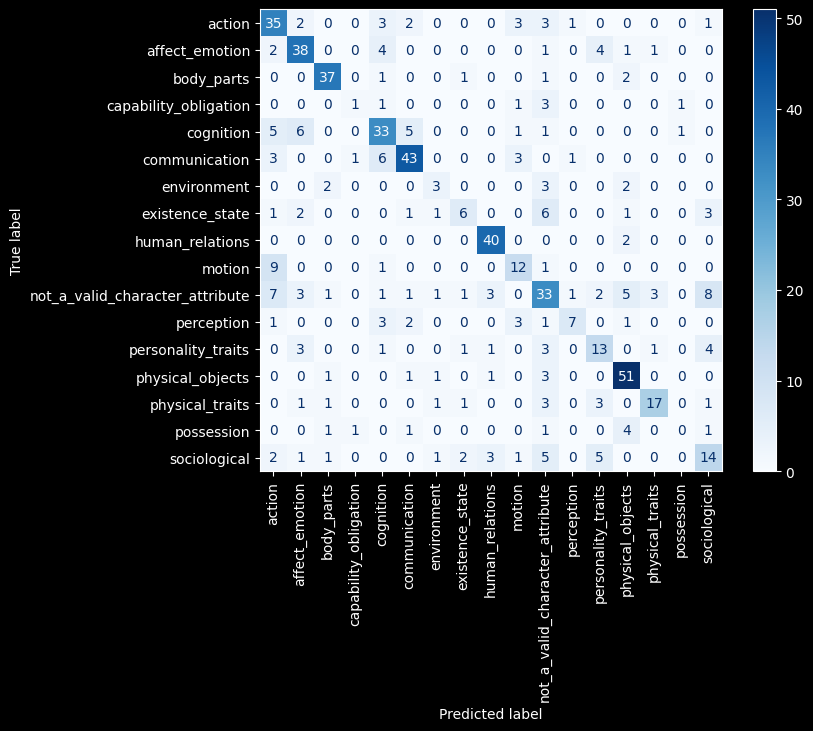

In [9]:
# Get all unique labels
classes = sorted(list(set(all_gold + all_preds)))

# Compute confusion matrix
cm = confusion_matrix(all_gold, all_preds, labels=classes)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# Rotate x-axis labels 45 degrees
disp.plot(cmap="Blues", xticks_rotation=90)

plt.gcf().set_size_inches(8, 6)  # optional, bigger figure
plt.show()

In [10]:
# final model training
train_loader = DataLoader(TensorDataset(X, Y), batch_size=32, shuffle=True)
total_loss, correct = 0, 0
# Model, loss, optimizer
ontology_model = Classifier(input_dim=input_dim,
                   dropout_rate=dropout_rate,
                   hidden_layer_width=hidden_layer_width,).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ontology_model.parameters(), lr=1e-3, weight_decay=1e-4)

# Training
for epoch in range(23):  # keep epochs small per fold
    ontology_model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)   # move minibatch to GPU
        optimizer.zero_grad()
        preds = ontology_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

# Save model weights + architecture info
checkpoint = {
    "input_dim": input_dim,
    "hidden_layer_width": hidden_layer_width,
    "dropout_rate": dropout_rate,
    "num_classes": num_classes,
    "state_dict": ontology_model.state_dict()
}

trained_model_path = os.path.join(annotated_attributes_data_path, "attributes_classification_model.pt")
torch.save(checkpoint, trained_model_path)

## Reload Trained Attributes Classifier

In [11]:
class Classifier(nn.Module):
    def __init__(self, input_dim=1024, dropout_rate=0.5, hidden_layer_width=512, num_classes=num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_layer_width),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_layer_width, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
            )

    def forward(self, x):
        return self.net(x)

def load_classifier_model(path, device=None):
    if not device:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(path, map_location=device)
    model = Classifier(
        input_dim=checkpoint["input_dim"],
        hidden_layer_width=checkpoint["hidden_layer_width"],
        dropout_rate=checkpoint["dropout_rate"],
        num_classes=checkpoint["num_classes"]
    ).to(device)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    return model

In [12]:
annotated_attributes_data_path = "annotated_attributes_data"

with open(os.path.join(annotated_attributes_data_path, "training_label_mapping.json"), "r", encoding="utf-8") as f:
    label2id = json.load(f)
id2label = {v: k for k, v in label2id.items()}

# Load checkpoint
trained_model_path = os.path.join(annotated_attributes_data_path, "attributes_classification_model.pt")
loaded_model = load_classifier_model(trained_model_path, device)
loaded_model

Classifier(
  (net): Sequential(
    (0): Linear(in_features=1028, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=64, out_features=17, bias=True)
  )
)